In [1]:
#DB
import os
import psycopg2

# Helpers
import numpy as np
from collections import defaultdict
import qgrid
from tqdm import tqdm_notebook
import time
import pandas as pd

# Preprocessing
from analyzer import python_analyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from vectorizer import NCutVectorizer

# Learning
from clustering import Clustering

# Evaluation
from sklearn.metrics import silhouette_samples, silhouette_score

# Plots
import matplotlib.pyplot as plt

%matplotlib notebook

## Data

In [2]:
topics = ["business", "entertainment", "politics", "sport", "tech"]
docs = []
base_path = "bbc"
for t in topics:
    docs_title = os.listdir("%s/%s" % (base_path,t))
    for item in docs_title:
        with open('%s/%s/%s' %(base_path, t, item), 'r') as txtfile:
            try:
                docs.append(txtfile.read())
            except UnicodeDecodeError:
                print("Error on doc %s/%s" % (t,item))

Error on doc sport/199.txt


### Preprocessing solutions into bag of words ###

In [130]:
import numpy as np
from itertools import permutations
N = 3
bagofwords = np.array([[3,2,0], [1,0,3], [0,1,2], [1,2,1]])
bagofwords[np.where(bagofwords > 1)] = 1
cooccurence = np.dot(bagofwords.T, bagofwords)
wt = np.array([[1,2], [2,0], [3,1]])
print(cooccurence)
for col in range(wt.shape[1]):
    idx = wt[:,col].argsort()[::-1][:N]
    combs = permutations(idx, 2)
    k_score = []
    for i,j in combs:
#         score = np.log((cooccurence[i,j]+0.01)/cooccurence[i,i])
        score = (cooccurence[i,j]+0.01)/cooccurence[i,i]
        k_score.append(score)
    k_coherence = (1/(N*(N-1)))*np.asarray(k_score).sum()
    print(k_coherence)

[[3 2 2]
 [2 3 2]
 [2 2 3]]
0.6699999999999999
0.6699999999999999


In [163]:
bagofwords

array([[1, 1, 0],
       [1, 0, 1],
       [0, 1, 1],
       [1, 1, 1]])

In [171]:
b = bagofwords[:,[0,2]]
b = b[[1,2],:]
b

array([[1, 1],
       [0, 1]])

In [186]:
def create_bag_of_words(docs, vectorizer_method, binary=False, min_df=0.2):
#     vectorizer = vectorizer_method(analyzer = python_analyzer,
    vectorizer = vectorizer_method(analyzer = 'word',
                                   binary=binary,
                                   min_df=min_df) 
    train_data_features = vectorizer.fit_transform(docs)
    try:
        train_data_features = train_data_features.toarray()
    # It's already an array
    except AttributeError:
        pass
    return train_data_features

def calculate_umass_coherence(X, word_topic, clusters, k, N=5):
    k_coherence = []
    for idx_cluster in range(k):
        cluster_data = X[clusters == idx_cluster]
        
        # If there aren't any documents assigned to the cluster, skip it
        if cluster_data.shape[0] == 0:
            continue
        
        # Calculate cooccurence matrix
        cluster_data[np.where(cluster_data > 1)] = 1
        cooccurence = np.dot(cluster_data.T, cluster_data)
        
        # For each topic, get N top words
        idx = word_topic[:,idx_cluster].argsort()[::-1][:N]
        combs = permutations(idx, 2)
        k_score = []
        for i,j in combs:
            if cooccurence[i,i] == 0:
                continue
            score = np.log((cooccurence[i,j]+0.01)/cooccurence[i,i])
            k_score.append(score)
        k_topic = np.mean(np.asarray(k_score))
        k_coherence.append(k_topic)
    return k_coherence, np.median(k_coherence), np.std(k_coherence)

In [195]:
%%time

vectorizers = CountVectorizer
min_df = 0.25
binary = True
method = 'nmf'
metric = 'cosine'

results = []
    
# Grid search
train_data_features = create_bag_of_words(docs, vectorizers, binary=binary, min_df=min_df)
print(train_data_features.shape)

# Remove rows containing only zeros (weird exercises)
solution_sample = train_data_features[~(train_data_features==0).all(1)]
if solution_sample.shape != train_data_features.shape:
    error = {
        "vectorizer": v,
        "min_df": m,
        "binary": b
    }
    print("ERROR: %s" % error)

clusters = range(2, int(np.sqrt(min(train_data_features.shape)))+1)
for k in tqdm_notebook(clusters):
    clustering = Clustering(train_data_features, k, metric=metric)
    model, document_topic, word_topic = getattr(clustering, method)()
    clusters = document_topic.argmax(axis=1)

    # UMass coherence
    k_coherence = calculate_umass_coherence(train_data_features, word_topic, clusters, k)

    results.append({
#         "model": model,
#         "method": method,
#         "vectorizer": v.__name__,
#         "min_df": m,
#         "binary": b,
#         "gap_avg": k_gap[0],
#         "gap_std": k_gap[1],
        "k": k,
#         "silhouette": k_silhouette,
#         "silhouette_samples": sample_silhouette_values,
        "X": train_data_features,
        "y": clusters,
#         "distance": dist,
        "coherence": k_coherence[0],
        "coherence_avg": k_coherence[1],
        "coherence_std": k_coherence[2],
        "found_k": len(k_coherence[0])
    })               

(2224, 91)



CPU times: user 3.21 s, sys: 2.35 s, total: 5.56 s
Wall time: 2.54 s


In [196]:
df = pd.DataFrame(results)

In [197]:
qgrid.show_grid(df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [198]:
coherence = df['coherence_avg'].values.tolist()
coherence_std = df['coherence_std'].values.tolist()
coherence_array = df['coherence'].values.tolist()

<IPython.core.display.Javascript object>


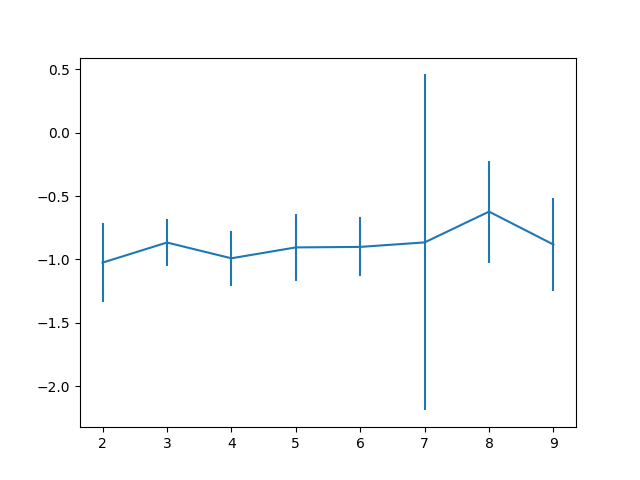

k = 8
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 37.8 ms


In [199]:
%%time

# Plot data
plt.figure()
plt.errorbar(range(2,len(coherence)+2), coherence, yerr=coherence_std)
# plt.show()

# Get best k
k = np.argmax(np.asarray(coherence))+2
# k = get_curve_knee(range(1,len(coherence)+1), coherence)
print("k = %d" % k)

<IPython.core.display.Javascript object>


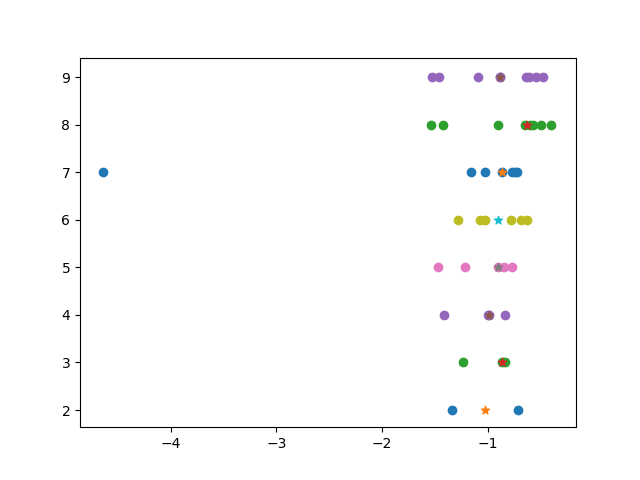

-1.0251487557049503
-0.8666579768780599
-0.9908730542913298
-0.905160166438502
-0.9011474761821658
-0.8656522115540219
-0.6229480307019755
-0.882625819007482


In [214]:
plt.figure()
for idx, i in enumerate(coherence_array):
    median = np.median(i)
    print(median)
    plt.scatter(i, [idx+2]*len(i))
    plt.scatter(median, idx+2, marker="*")

In [ ]:
import pickle

with open("clustering_bcc.pkl", "wb") as pklfile:
    pklfile.dump(df)